
# **TC4033.11**
# Visión computacional para imágenes y video

## Actividad 7
### Algoritmos de extracción de características  | Parte 1

## Prof. Titular
Dr. Gilberto Ochoa Ruiz

## Prof.Tutor
Francisco Solorzano Domínguez

## Equipo 31
### Integrantes
* Juan Felipe Caro Valencia -                   A01796224
* Ada Jimena Vargas Aguirre   -                 A01701619
* Irving Morales Cedeño -                       A01796208
* Marco Polo Navarrete Rodríguez -              A01796238
---


# Learning goal

En el Colab de Harris Detector, se sugiere que se hagan pruebas con imágenes propias que el equipo decida usar. La idea  es escoger un objeto y tomar fotos con diferentes tipos de iluminación (bajo el sol, en un lugar oscuro) y bajo diferentes ángulos para analizar el comportamiento del detector de Harris bajo diferentes settings.

# 7. Harris Edge & Corner Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Color image to Grayscale conversion](#grayscale)
3. [Spatial derivative calculation](#spatial)
4. [Structure tensor setup](#tensor)
5. [Harris response calculation](#response)
6. [Find edges and corners using R](#find)
7. [Task](#find)
8. [Conclusion](#conclusion)
9. [Bibliography and references](#bibref)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage.filters import convolve


from PIL import Image

from matplotlib import image as mpimg
import urllib.request

from google.colab import files
import os, glob

/tmp/ipython-input-3246006935.py:5: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [2]:
print("Favor de subir el JSON con el API Key de Kaggle")
files.upload()

# Crear directorio de Kaggle y mover el archivo
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Favor de subir el JSON con el API Key de Kaggle


Saving kaggle.json to kaggle.json


In [3]:
# Descargar datasets necesarios

#### DATASET 1 ###
print("Descarga de Dataset 1")
!mkdir -p /content/data
!kaggle datasets download -d zaraks/pascal-voc-2007
!unzip -q pascal-voc-2007.zip -d /content/temp
!mv /content/temp/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/* /content/data
!rm -r /content/temp
!rm pascal-voc-2007.zip


Descarga de Dataset 1
Dataset URL: https://www.kaggle.com/datasets/zaraks/pascal-voc-2007
License(s): other
 98% 1.61G/1.65G [00:12<00:00, 67.7MB/s]
100% 1.65G/1.65G [00:12<00:00, 145MB/s] 


In [4]:
imgs = []
folder_path = '/content/data/'
file_list = os.listdir(folder_path)

for filename in file_list:
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img = Image.open(os.path.join(folder_path, filename))
        imgs.append(np.array(img))

## 1. Color to Grayscale <a class="anchor" id="grayscale" ></a>

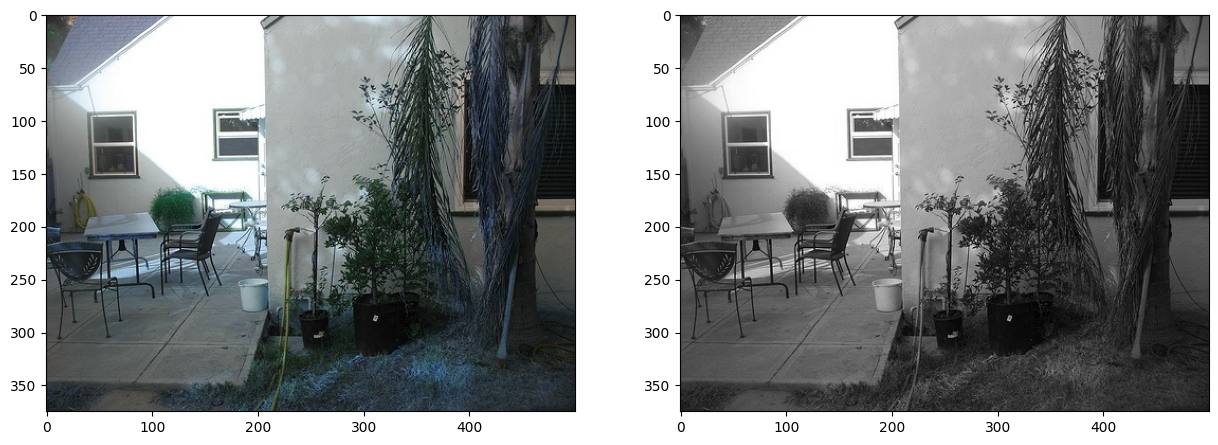

In [5]:
#img = cv2.imread('data/kitty_front_w_01.jpg')
img = imgs[0]
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 2. Spatial derivative calculation <a class="anchor" id="spatial" ></a>

In [6]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

## 3. Structure tensor setup <a class="anchor" id="tensor" ></a>

In [7]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

## 4. Harris response calculation <a class="anchor" id="response" ></a>

In [8]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy

harris_response = detA - k * traceA ** 2

In [9]:
img_gray.shape

(375, 500)

In [10]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [11]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

## 5. Find edges and corners using R <a class="anchor" id="find" ></a>

In [12]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

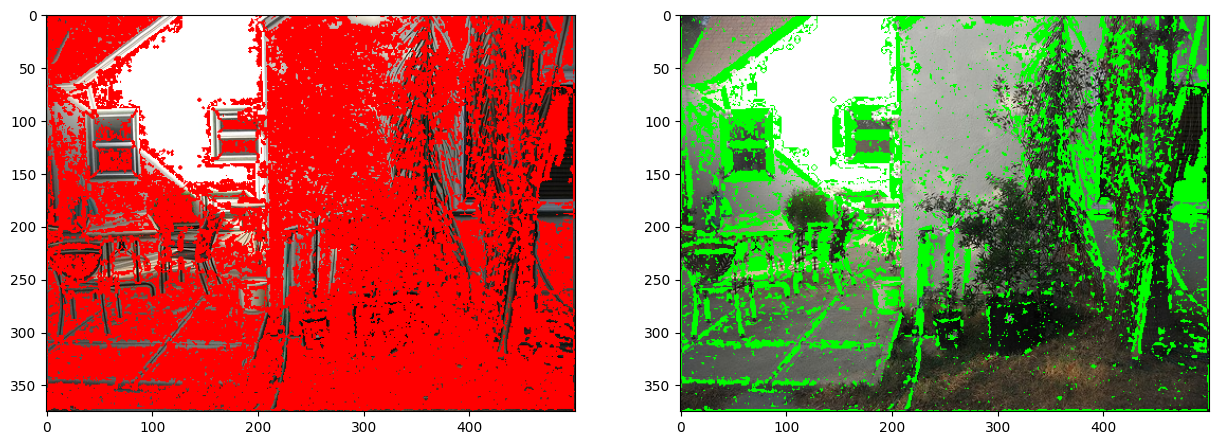

In [13]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

# **Task** <a class="anchor" id="task" ></a>

En las imágenes se observa que se está detectando todo, tanto la figura como el ruido (como la textura de la pared y los reflejos de la base). Se considera que esto se debe principalmente a la ausencia de un umbral, las condiciones `r>0` y `r<0` resultan demasiado estrictas dado que en un entorno real es poco probable que un pixel sea exactamente cero por la variación que exista por el ruido.

Por ello se procedió de la siguiente manera:

In [14]:
# Se añade el parámetro de "boundary = 'symm'" para colocar padding/relleno
# con la misma imagen espejeada y evitar bordes que no existen


def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same', boundary='symm')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same', boundary='symm')

In [15]:
# Función para filtrar respuestas con base en un umbral establecido por el usuario

def harris_edge_corner_detection(img_bgr,thresh = 0.01, scale = 100, k = 0.05, window_size = 3, sigma = 1):

  """
  Args:
    img: Imagen a analizar (en BGR de OpenCV)
    thresh: Umbral relativo, es el porcentaje del R máximo
    scale : Reescalamiento (%)
    k: Constante de sensibilidad de Harris
    window_size: Tamaño de la ventana Gaussiana (3,5 o 7 por ejemplo)
    sigma: Desviación estándar del filtro Gaussiano
  """
  # Reescalamiento para imágenes grandes
  if scale != 100:
    width = int(img_bgr.shape[1] * scale/100)
    height = int(img_bgr.shape[0] * scale/100)
    dim = (width,height)
    img_bgr = cv2.resize(img_bgr, dim, interpolation = cv2.INTER_AREA)

  # Convertir a escala de grises
  img_color = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB) # para mostrar
  img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

  # Cálculo de gradiente (Kernels de operador Sobel, se usa la función ya definida)
  I_x = gradient_x(img_gray)
  I_y = gradient_y(img_gray)

  # Configuración de tensor
  Ixx = convolve(I_x**2, gaussian_kernel(window_size,sigma))
  Ixy = convolve(I_x* I_y, gaussian_kernel(window_size,sigma))
  Iyy = convolve(I_y**2, gaussian_kernel(window_size,sigma))

  # Cálculo de respuesta de Harris
    # Determinante
  detA = Ixx * Iyy - Ixy ** 2
    # Traza
  traceA = Ixx + Iyy
    # Respuesta de Harris
  R = detA - k * traceA ** 2

  # Encontrar bordes y esquinas
  img_corners = np.copy(img_color)
  img_edges = np.copy(img_color)

    # Definir umbral con base en el parámetro relativo (o porcentaje)
  thresh_real_value = R.max() * thresh
    # Dibujar esquinas en cyan
    # Buscar coordenadas (y,x) donde se cumpla la condición
  corners_coords = np.where(R > thresh_real_value)
  img_corners[corners_coords] = [0, 255 , 255]
    # Dibujar bordes en verde
    # Buscar coordenadas (y,x) donde se cumpla la condición
  edges_coords = np.where(R < -thresh_real_value) # Valor neg. grande --> borde fuerte
  img_edges[edges_coords] = [0 , 255 , 0]


  return img_corners, img_edges

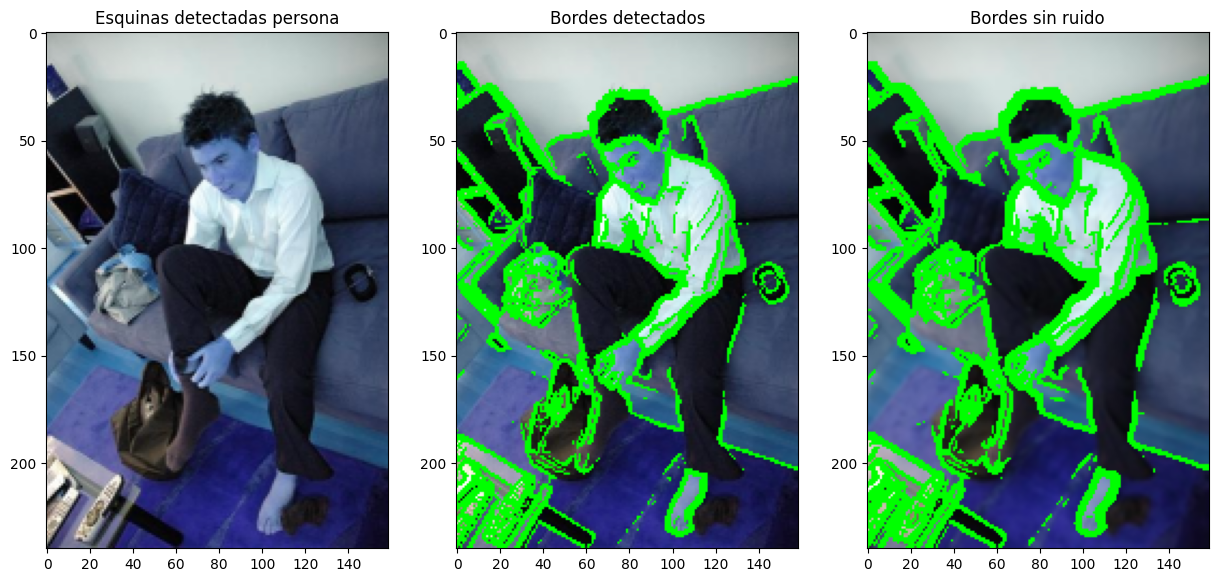

In [16]:
#img = cv2.imread('data/kitty_front_w_01.jpg')
img = imgs[1]
imgb = cv2.blur(img,(5,5))
_, edgesb = harris_edge_corner_detection(imgb, thresh = 1,
                                              scale = 50, window_size = 5, sigma = .29)
corners, edges = harris_edge_corner_detection(img, thresh = 1,
                                              scale = 50, window_size = 5, sigma = .29)


# Imprimir resultados
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(corners)
plt.title("Esquinas detectadas persona")

plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(edgesb)
plt.title("Bordes sin ruido")
plt.show()


Se observa que se entiende perfectamente los bordes a pesar de que la paleta de colores es fria, pero mientras menor es el contraste más trabajo le cuesta definir esquinas y bordes, se ve que el proceso de reducción de ruido mejora la detección de bordes.

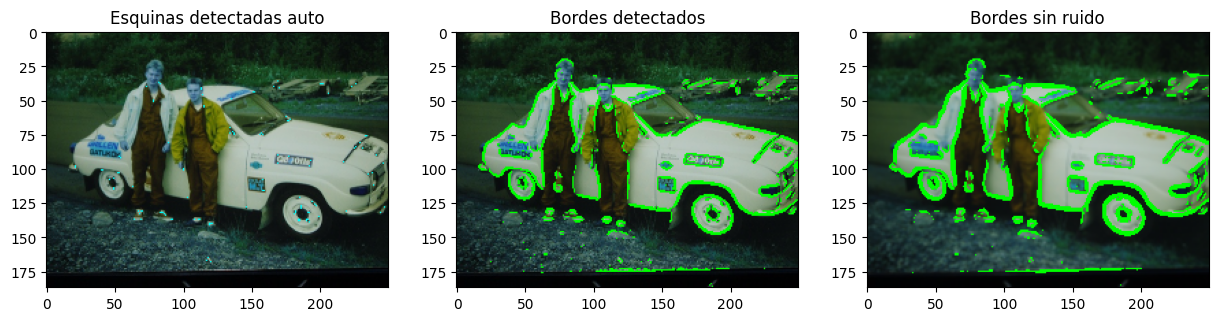

In [17]:
img = cv2.imread('data/kitty_front_w_01.jpg')
img = imgs[2]
imgb = cv2.blur(img,(5,5))
corners, edges = harris_edge_corner_detection(img, thresh = 0.1,
                                              scale = 50, window_size = 3, sigma = .4)
_, edgesb = harris_edge_corner_detection(imgb, thresh = 0.1,
                                              scale = 50, window_size = 3, sigma = .4)
# Imprimir resultados
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(corners)
plt.title("Esquinas detectadas auto")

plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(edgesb)
plt.title("Bordes sin ruido")

plt.show()

En este caso a pesar de la mejora en la detección de bordes y esquinas por el filtro ruido, vemos que necesita trabajo adicional sin embargo se aprecia una mejora considerable.

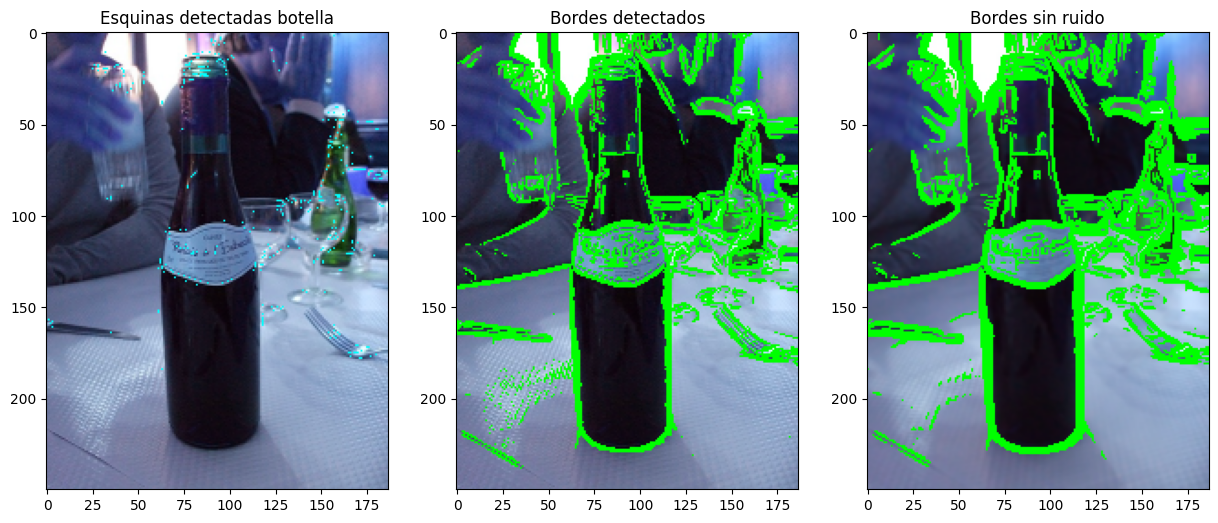

In [18]:
#img = cv2.imread('data/kitty_front_w_01.jpg')
img = imgs[3]
imgb = cv2.blur(img,(5,5))
corners, edges = harris_edge_corner_detection(img, thresh = .008,
                                              scale = 50, window_size = 3, sigma = .35)
_, edgesb = harris_edge_corner_detection(imgb, thresh = .008,
                                              scale = 50, window_size = 3, sigma = .35)
# Imprimir resultados
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(corners)
plt.title("Esquinas detectadas botella")

plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(edgesb)
plt.title("Bordes sin ruido")

plt.show()

En las tres muestras anteriores se puede observar la utilidad de contar con un umbral, además de cómo el ajuste de parámetros tiene un impacto directo sobre qué se detecta como esquina o borde.

Por ejemplo, un `window_size = 3` permite ver detalles más finos que al usar un tamaño de 5, pero resulta más sensible al ruido. De manera similar, un umbral demasiado exigente resultará mucho más sensible al ruido (por ende se tendrán más puntos).



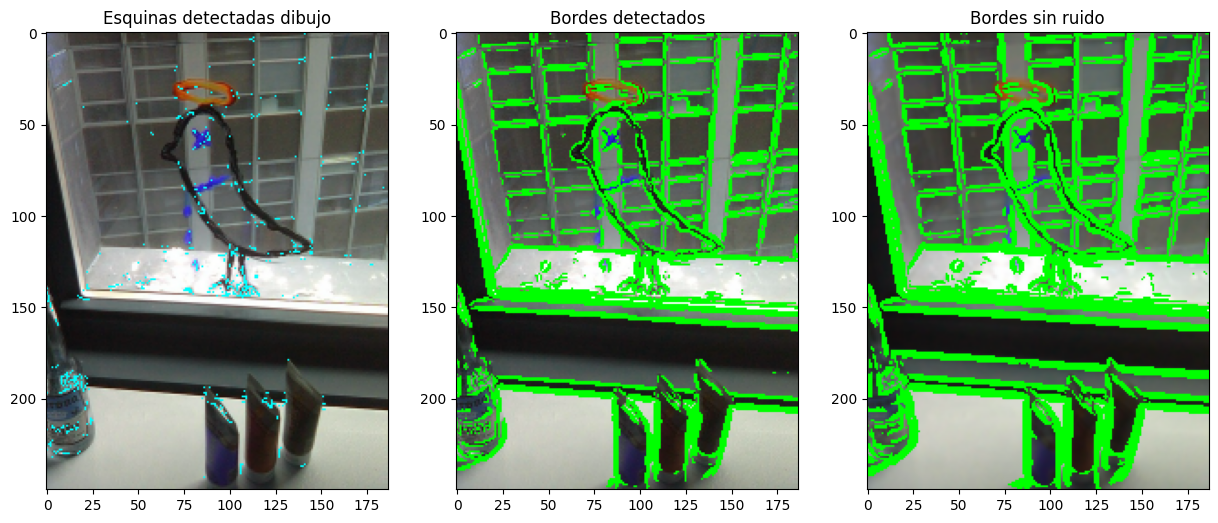

In [19]:
#img = cv2.imread('data/kitty_front_fe.jpg')
img = imgs[4]
imgb = cv2.blur(img,(5,5))
corners, edges = harris_edge_corner_detection(img, thresh = 0.001,
                                              scale = 50, window_size = 3, sigma = .4)
_, edgesb = harris_edge_corner_detection(imgb, thresh = 0.001,
                                              scale = 50, window_size = 3, sigma = .4)
# Imprimir resultados
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(corners)
plt.title("Esquinas detectadas dibujo")

plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(edgesb)
plt.title("Bordes sin ruido")

plt.show()

En este caso los umbrales ayudan en una mejor detección de esquinas y bordes y el filtro de ruido exponencía esa mejora, como en el caso de los objetos de la mesa, de igual forma el dibujo es detectado perfectamente.

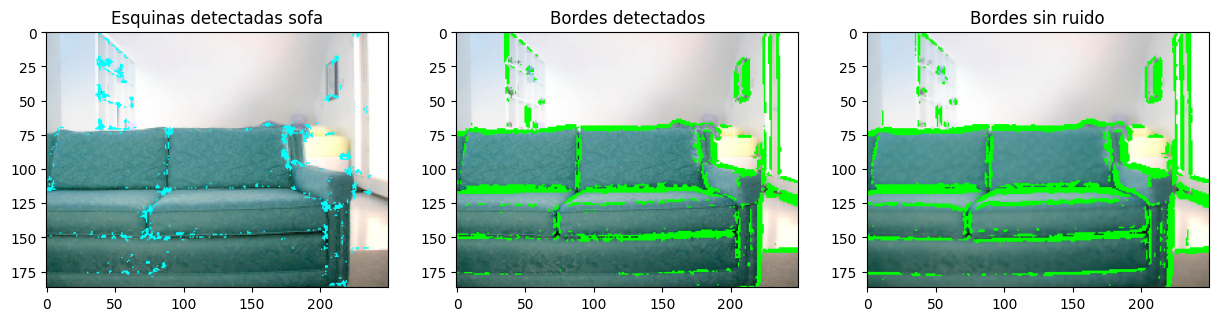

In [20]:
#img = cv2.imread('data/kitty_front_fe.jpg')
img = imgs[5]
imgb = cv2.blur(img,(5,5))
corners, edges = harris_edge_corner_detection(img, thresh = .001,
                                              scale = 50, window_size = 3, sigma = .6)
_, edgesb = harris_edge_corner_detection(imgb, thresh = .001,
                                              scale = 50, window_size = 3, sigma = .6)
# Imprimir resultados
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(corners)
plt.title("Esquinas detectadas sofa")

plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(edgesb)
plt.title("Bordes sin ruido")

plt.show()

En este caso se corrobora cómo la figura de la puerta está generando más ruido al tener un umbral relativo menor y genera una mayor cantidad de esquinas falsas detectadas, el resultado tras la apliación del filtro es muy superior.

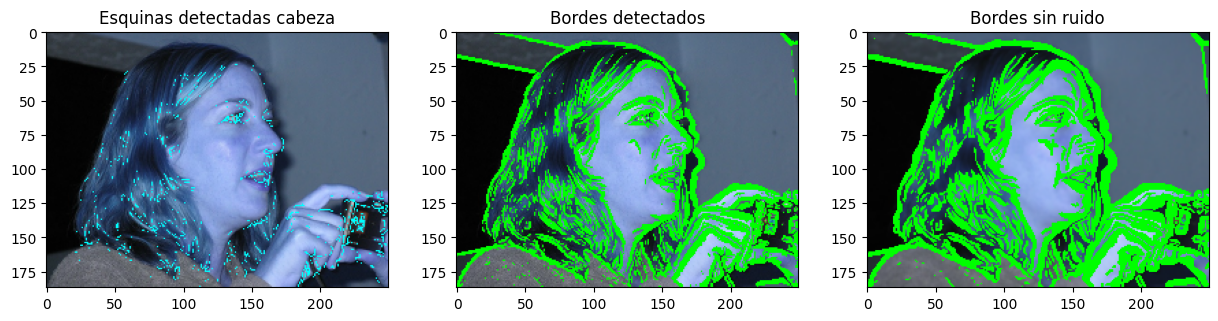

In [21]:
#img = cv2.imread('data/kitty_guitar_ext01.jpg')
img = imgs[6]
imgb = cv2.blur(img,(5,5))
corners, edges = harris_edge_corner_detection(img, thresh = 0.001,
                                              scale = 50, window_size = 3, sigma = .4)
_, edgesb = harris_edge_corner_detection(imgb, thresh = 0.001,
                                              scale = 50, window_size = 3, sigma = .4)
# Imprimir resultados
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(corners)
plt.title("Esquinas detectadas cabeza")

plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(edgesb)
plt.title("Bordes sin ruido")

plt.show()

Aunque hay muchas esquinas y por lo tanto los bordes son amplios, harris pudo detectar de forma sobresaliente los bordes debido en gran medida al alto contraste, y nuevamente el filtro hace que el resultado sea superior.

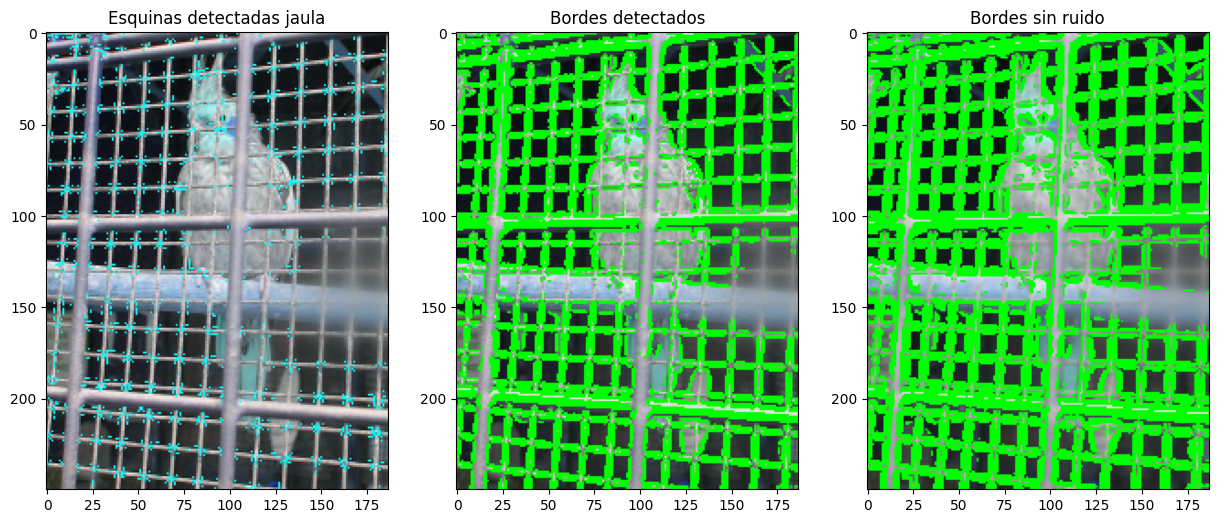

In [22]:
#img = cv2.imread('data/kitty_guitar_carpet00.jpg')
img = imgs[7]
imgb = cv2.blur(img,(5,5))
corners, edges = harris_edge_corner_detection(img, thresh = 0.01,
                                              scale = 50, window_size = 3, sigma = 0.4)
_, edgesb = harris_edge_corner_detection(imgb, thresh = 0.01,
                                              scale = 50, window_size = 3, sigma = 0.4)

# Imprimir resultados
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(corners)
plt.title("Esquinas detectadas jaula")

plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(edgesb)
plt.title("Bordes sin ruido")

plt.show()

En los dos últimos experimentos se aprecia mejor cómo las texturas de fondo influyen en la detección, a pesar de tener un umbral menos sensible y una ventana con mayor tamaño. Se confirma que este detector tiene un alto desempeño en figuras con alto contraste.


## **Conclusion** <a class="anchor" id="conclusion" ></a>

Con base en las imágenes analizadas, se piensa que la aplicación del detector Harris requiere particular atención al ajustar sus parámetros, dado las siguientes observaciones en su comportamiento:

* En cada prueba se percibe que el detector no "comprende" qué es una pared o diferenciar los elementos detras del objeto y el objeto en cuestión, únicamente se limita a analizar matemáticamente (esto se puede ver cuándo considera como esquina al reflejo de la superficie metálica o alguna parte de la jaula).
* La configuración de los parámetros es crucial, el resultado depende directamente de esta acción. Por ejemplo, establecer un umbral permite controlar la "sensibilidad", un valor bajo podría detectar detalles muy finos, mientras que uno alto podría filtrar demasiado, incluso verdaderas esquinas o bordes.

Una vez mencionado lo anterior, se concluye que Harris es un detector potente pero con ciertas flaquezas. Mientras que su fortaleza radica en la rapidez para hallar candidatos a esquinas o bordes sin verse afectado por la rotación y, parcialmente, la iluminación, su debilidad se encuentra en su incapacidad para describir lo que detecta, es decir, no es posible saber si una esquina A en la imagen 1 corresponde a la esquina B de la imagen 2. Además, Harris se ve afectado por la escala.

Si bien Harris ha sido un pilar para el desarrollo de herramientas más complejas donde se localicen puntos de interés, se considera una herramienta que requiere ser complementada para poder ejecutar tareas de emparejamiento entre más de una imagen.

De igual manera se observa que como mejores prácticas debe ser utilizado con un filtro de eliminación de ruido que nos permita aumentar el umbral de detección, también que la estrategia de umbralización puede ser muy efectiva para obtener mejores resultados y reducir el consumo de ciclos de procesamiento. Jasani et al 2017.

# **Bibliography and references** <a class="anchor" id="bibref" ></a>


* Gonzalez, R. C., y Woods, R. E. (2018). *Digital Image Processing, Global Edition* (4th ed.). Pearson International Content. https://tec.vitalsource.com/books/9781292223070

* Solem, J.E.. (2012). *Programming Computer Vision with Pyhton*. O'Reilly Media, Inc. https://learning.oreilly.com/library/view/programming-computer-vision/9781449341916

* Jasani, B. A., Lam, S. K., Meher, P. K., & Wu, M. (2017). Threshold-guided design and optimization for harris corner detector architecture. IEEE Transactions on Circuits and Systems for Video Technology, 28(12), 3516-3526. https://www.tum-create.edu.sg/sites/default/files/files/Jasani2018ThresholdSMAT.pdf



